In [116]:
# Locate project root dir, enable package imports from src/
import sys
from pathlib import Path

PROJ_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJ_ROOT / "src"))
print(PROJ_ROOT)

/Users/alexandre/Documents/GitHub/price_predictor


In [117]:
import os
import json
import math

# Load standardized paths and cleaning utilities
from project_utils.paths import RAW_DATA_DIR, CLEANED_DATA_DIR
import project_utils.cleaning_utils as cleaning_utils


# ΦK correlation coefficient and supporting visualization libraries
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# Data handling and manipulation
import pandas as pd
import numpy as np

# Text processing and string matching
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [118]:
# Importing raw data
df_train = pd.read_csv(os.path.join(RAW_DATA_DIR, "train.csv"), index_col="carID")
df_test = pd.read_csv(os.path.join(RAW_DATA_DIR, "test.csv"), index_col="carID")

In [119]:
# Checking for duplicated unique car ID values
print("df_train:", df_train.index.is_unique)
print("df_test:", df_test.index.is_unique)

df_train: True
df_test: True


Their primary objective of this project is to expedite the evaluation process by developing a predictive model capable of estimating a car’s price based solely on user-provided inputs, without requiring the vehicle to be physically inspected by a mechanic. According to the dataset metadata, the feature 'paintQuality%' is recorded by a mechanic during the evaluation process. As this information would not be available at the time of user input, the feature was removed from the entire dataset.

In [120]:
# Removing 'paintQuality%' from df_train and df_test
df_train.drop("paintQuality%", axis=1, inplace=True)
df_test.drop("paintQuality%", axis=1, inplace=True)

In [121]:
# df_train numerical features
numeric_features = df_train.select_dtypes(exclude="object").copy()
numeric_features.drop(columns="price", inplace=True)
# df_test numerical features
numeric_test = df_test.select_dtypes(exclude="object").copy()

In [122]:
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


An examination of the descriptive statistical summary of the training dataset reveals several noteworthy issues:
1. Skewed Distributions
Features such as 'mileage' and 'tax' exhibit substancial differences between their mean and median values, indicating pronounced skewness in their distributions. Furthermore, the target variable (price) also displays a similar pattern, suggesting that its distribution is likewise skewed.

2. Invalid Numerical Values
The features 'mileage', 'tax', 'mpg', 'engineSize' and 'previousOwners'  contain negative values, which are not physically meaningful according to the dataset’s metadata. These entries likely correspond to data entry errors or inconsistencies and therefore require correction or removal prior to downstream analysis.

3. Implausible Feature Ranges
The 'year' variable reaches a maximum of approximately 2024, despite the metadata indicating that vehicle information should only extend up to 2020. Similarly, the 'paintQuality' feature displays values up to approximately 125%, which is not realistic. These anomalies suggest further data quality issues that must be addressed.

4. Non-Informative Feature
The 'hasDamage' variable contains only a single observed value (0) across all records, indicating complete lack of variability.

The anomalies described in points 1 to 3 will be rectified as part of the present data-cleaning workflow. Whereas the issue highlighted in point 4 will be evaluated during the feature-selection phase.

In [123]:
numeric_test.describe().T

,count,mean,std,min,25%,50%,75%,max
year,31914.0,2017.102299,2.207969,1991.000000,2016.00,2017.0,2019.0,2024.121759
mileage,31878.0,22952.658921,22132.758713,-58540.574478,7298.25,17225.5,32500.0,279000.000000
tax,29259.0,120.569239,65.560570,-91.121630,125.00,145.0,145.0,580.000000
mpg,29279.0,55.210728,17.644635,-43.421768,46.30,54.3,62.8,470.800000
engineSize,31939.0,1.665377,0.574467,-0.103493,1.20,1.6,2.0,6.600000
previousOwners,31970.0,2.006118,1.472310,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,31970.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


Moreover, the provided test set exhibits the same data entry inconsistencies, indicating that these issues affect both splits of the dataset.

# Correcting invalid data entries

To resolve these issues, all invalid entries in both the training and test sets were corrected. In the case of the test set, the original row count had to be preserved to maintain index compatibility for downstream prediction submission; therefore, correction rather than removal was required.

In [124]:
# Correcting 'year'
# df_train
year_mask = numeric_features["year"] > 2020.0
numeric_features = numeric_features[~year_mask]

# df_test
test_year_mask = numeric_test["year"] > 2020
numeric_test["year"] = numeric_test["year"].mask(test_year_mask, other=2020.0)

In [125]:
# Correcting negative values
# df_train
negative_mask = (numeric_features < 0).any(axis=1)
numeric_features = numeric_features[~negative_mask]

# df_test
test_negative_mask = numeric_test < 0
numeric_test[test_negative_mask] = numeric_test[test_negative_mask].abs()

In [126]:
print(
    f"Percentage of retained data after removing invalid entries: "
    f"{round(numeric_features.shape[0] / df_train.shape[0] * 100, 2)}%"
)

Percentage of retained data after removing invalid entries: 97.92%


In [127]:
# Applying corrections to DataFrames
df_train[numeric_features.columns] = numeric_features[numeric_features.columns]
df_test[numeric_test.columns] = numeric_test[numeric_test.columns]

## Categorical features

In [128]:
categories = df_train.select_dtypes(include="object").copy()
categories

,Brand,model,transmission,fuelType
carID,,,,
69512,VW,Golf,Semi-Auto,Petrol
53000,Toyota,Yaris,Manual,Petrol
6366,Audi,Q2,Semi-Auto,Petrol
29021,Ford,FIESTA,anual,Petrol
10062,BMW,2 Series,Manual,Petrol
...,...,...,...,...
37194,Mercedes,C Class,Manual,etrol
6265,Audi,Q3,Semi-Auto,Diesel
54886,Toyota,Aygo,Automatic,Petrol


A preliminary inspection of the data reveals several misspelled entries (e.g., Petrol, etrol). Before proceeding to model building and evaluation, these invalid textual entries must be corrected to ensure consistency across the categorical variables and to reduce the number of unique values within each feature.

To address these inconsistencies, we apply Python’s SequenceMatcher, which identifies the closest valid label for each misspelled value based on a similarity ratio computed between strings. Given two strings, the similarity ratio is defined as:
$$
ratio = \frac{2M}{T}
$$
+ Where:
    + $ M$ denotes the number of matching characters
    + $ T$ is the total number of characters in both strings

Despite its simplicity, the approach demonstrated strong performance in correcting minor typographical inconsistencies and ensuring a consistent representation of categorical text values throughout the dataset.

## Fixing brand names

In [129]:
categories.query("Brand.notnull()")["Brand"].unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', 'yundai',
       'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel', 'For',
       'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD',
       'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA',
       'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod',
       'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI',
       'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede',
       'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod',
       'toyot'], dtype=object)

As suspected, several brand names are misspelled, and there are inconsistencies in the use of upper- and lowercase characters across the categorical variables. To address these issues, all categorical features were normalised to lowercase, thereby simplifying the correction of textual inconsistencies and ensuring uniformity throughout the dataset.

In [130]:
# Creates new DataFrame with normalized columns
corrected_category_df = categories.map(
    lambda x: np.nan if pd.isna(x) else str(x).strip().lower()
).copy()

In [131]:
valid_brands = [
    "toyota",
    "mercedes",
    "vw",
    "audi",
    "ford",
    "bmw",
    "opel",
    "hyundai",
    "skoda",
]

# Correct brand entries
corrected_category_df["Brand"] = corrected_category_df["Brand"].apply(
    lambda brand: cleaning_utils.category_analyzer(brand, valid_brands)
)


In [132]:
corrected_category_df.groupby("Brand")["model"].unique()

Brand
audi        [q2, a3, q3, q5, tt, a1, a8, a4, a5, a6, q7, q...
bmw         [2 series, 3 series, 5 series, 4 series, x3, x...
ford        [fiesta, focus, ka+, ecosport, ecospor, nan, b...
hyundai     [i30, tucson, ix20, i20, kona, i10, ioniq, san...
mercedes    [a clas, a class, glc class, c class, e class,...
opel        [insignia, mokka x, corsa, astra, viva, adam, ...
skoda       [octavia, fabia, rapid, yeti outdoor, scala, k...
toyota      [yaris, c-hr, aygo, auris, rav4, prius, coroll...
vw          [golf, passat, polo, up, sharan, tiguan, t-roc...
Name: model, dtype: object

## Fixing model names


In [133]:
# Dictionary of 'model' per 'brand' (sorted by frequency)
sort_by_freq = (
    corrected_category_df.groupby("Brand")["model"]
    .value_counts()
    .groupby(level=0)
    .apply(lambda s: s.index.get_level_values("model").tolist())
    .to_dict()
)

To further reduce textual inconsistencies in the model feature, an automated correction procedure was implemented using character-level TF–IDF embeddings and cosine similarity. This approach allows misspelled or near-duplicate model names to be mapped to their most common, standardised counterparts within each brand.

In [134]:
# Contants
NGRAM = (2, 3)  # Character n-gram range used for TF-IDF encoding
THR = 0.8  # Minimum cosine similarity required to assign a correction
K = 18  # Number of top-frequency model names used as anchor references

correct_dict = {}

for brand in valid_brands:
    # Stores model names sorted by frequency and vecotrizes them
    uniq = np.array(sort_by_freq[brand], dtype=object)
    vec = TfidfVectorizer(analyzer="char", ngram_range=NGRAM)
    X = vec.fit_transform(uniq)

    # Vectorize the top-K most frequent model names (anchors)
    A = vec.transform(uniq[: min(K, len(uniq))])

    # Comput cosine similarity between each model anme and the anchor set
    S = cosine_similarity(X, A)

    # Identify the most similar anchor for each 'model'
    best_idx = S.argmax(axis=1)
    best_sim = S.max(axis=1)

    # Assign corrected labels where similarity exceeds the threshold
    assigned = np.where(best_sim >= THR, uniq[best_idx], uniq)

    # Store corrected model names for the current brand
    correct_dict[brand] = assigned

# Applies 'model' label corrections
corrected_category_df["model"] = cleaning_utils.model_cleaner(
    corrected_category_df, correct_dict, valid_brands
)

In [135]:
# List of corrected models per brand
for brand in valid_brands:
    print(f"{brand}:")
    print(
        corrected_category_df.query("Brand == @brand")["model"].unique(),
        "\n" + "-" * 50,
    )

toyota:
['yaris' 'c-hr' 'aygo' 'auris' 'rav4' 'prius' 'corolla' nan 'verso' 'ayg'
 'gt86' 'land cruiser' 'proace verso' 'hilux' 'avensis' 'camry' 'yari'
 'supra' 'c-h' 'verso-s' 'auri' 'iq' 'rav' 'urban cruiser' 'urban cruise'] 
--------------------------------------------------
mercedes:
['a class' 'glc class' 'c class' 'e class' 'c clas' 'slk' 'x-class'
 'cl class' 'gls class' 'gle class' 's class' 'gla class' 'sl class'
 'b class' 'v class' nan 'cls class' 'cla class' 'gl class' 'm class'
 'clk' 'g class' 'glb class' '200' '220' '230' 'm clas' 'sl' 'clc class'] 
--------------------------------------------------
vw:
['golf' 'passat' 'polo' 'up' 'sharan' 'tiguan' 't-roc' 'arteon' nan
 'touran' 'caddy maxi life' 'beetle' 'touareg' 'shuttle' 'tiguan allspace'
 'caravelle' 'pol' 't-cross' 'golf sv' 'gol' 'california' 'caddy life'
 'scirocco' 'amarok' 'cc' 'eos' 'jetta' 'u' 'caddy maxi' 'caddy' 'beetl'
 'fox' 'caddy maxi lif'] 
--------------------------------------------------
audi:
['q

Since some model names remained unstandardised (e.g., gol instead of golf), a dictionary of corrected model labels was employed to resolve these residual inconsistencies.

In [136]:
cleaned_dict_dir = os.path.join(
    PROJ_ROOT, "src", "project_utils", "cleaned_models.json"
)

with open(cleaned_dict_dir, "r") as f:
    brand_models_dict = json.load(f)
corrected_category_df["model"] = cleaning_utils.model_cleaner(
    corrected_category_df, brand_models_dict, valid_brands
)

In [137]:
# List of corrected models per brand
for brand in valid_brands:
    print(f"{brand}:")
    print(
        corrected_category_df.query("Brand == @brand")["model"].unique(),
        "\n" + "-" * 50,
    )

toyota:
['yaris' 'c-hr' 'aygo' 'auris' 'rav4' 'prius' 'corolla' nan 'verso' 'gt86'
 'land cruiser' 'proace verso' 'hilux' 'avensis' 'camry' 'supra' 'verso-s'
 'iq' 'urban cruiser'] 
--------------------------------------------------
mercedes:
['a class' 'glc class' 'c class' 'e class' 'slk' 'x-class' 'cl class'
 'gls class' 'gle class' 's class' 'gla class' 'sl class' 'b class'
 'v class' nan 'cls class' 'cla class' 'gl class' 'm class' 'clk'
 'g class' 'glb class' 'clc class'] 
--------------------------------------------------
vw:


['golf' 'passat' 'polo' 'up' 'sharan' 'tiguan' 't-roc' 'arteon' nan
 'touran' 'caddy maxi life' 'beetle' 'touareg' 'shuttle' 'caravelle'
 't-cross' 'golf sv' 'california' 'caddy life' 'scirocco' 'amarok' 'cc'
 'eos' 'jetta' 'caddy maxi' 'caddy'] 
--------------------------------------------------
audi:
['q2' 'a3' 'q3' 'q5' 'tt' 'a1' 'a8' 'a4' 'a5' 'a6' 'q7' 'q8' nan 'rs6'
 'a7' 'rs5' 'r8' 'rs3' 'sq5' 'rs4' 'sq7' 's3' 's4' 'a2' 's8' 's5'] 
--------------------------------------------------
ford:
['fiesta' 'focus' 'ka+' 'ecosport' nan 'b-max' 's-max' 'mondeo' 'kuga'
 'grand tourneo connect' 'galaxy' 'ka' 'tourneo custom' 'c-max' 'puma'
 'grand c-max' 'edge' 'fusion' 'mustang' 'escort' 'streetka' 'ranger'] 
--------------------------------------------------
bmw:
['2 series' '3 series' '5 series' '4 series' 'x3' 'x2' 'x1' '1 series' nan
 'm3' 'x4' 'm4' 'z4' 'x5' '6 series' 'x7' 'x6' '8 series' 'z3' '7 series'
 'i3' 'i8' 'm5' 'm6' 'm2'] 
--------------------------------------------------
op

## Accessing remaining categorical features

In [138]:
np.sort(corrected_category_df.query("transmission.notnull()")["transmission"].unique())

array(['anua', 'anual', 'automati', 'automatic', 'emi-aut', 'emi-auto',
       'manua', 'manual', 'nknow', 'nknown', 'other', 'semi-aut',
       'semi-auto', 'unknow', 'unknown', 'utomati', 'utomatic'],
      dtype=object)

In [139]:
np.sort(corrected_category_df.query("fuelType.notnull()")["fuelType"].unique())

array(['diese', 'diesel', 'electric', 'etro', 'etrol', 'hybri', 'hybrid',
       'iese', 'iesel', 'othe', 'other', 'petro', 'petrol', 'ther',
       'ybri', 'ybrid'], dtype=object)

In [140]:
# Lists of valid categories
valid_transmission = ["manual", "semi-auto", "automatic", "other", "unknown"]
valid_fuelTypes = ["petrol", "diesel", "hybrid", "electric", "other"]

# Apply correction to 'transmission'
corrected_category_df["transmission"] = corrected_category_df["transmission"].apply(
    lambda val: cleaning_utils.category_analyzer(val, valid_transmission)
)
# Apply correction to 'fuelTypes'
corrected_category_df["fuelType"] = corrected_category_df["fuelType"].apply(
    lambda val: cleaning_utils.category_analyzer(val, valid_fuelTypes)
)

In [141]:
# Replacing columns on original df with cleaned ones
df_train[categories.columns] = corrected_category_df[categories.columns]

### Test set categories

In [143]:
# Normalizes the test df categoricals
normalized_df_test = df_test.select_dtypes(include="object").copy()
normalized_df_test = normalized_df_test.map(
    lambda x: np.nan if pd.isna(x) else str(x).strip().lower()
)

##-- Data cleaning --##

# 'Brand' column
normalized_df_test["Brand"] = normalized_df_test["Brand"].apply(
    lambda brand: cleaning_utils.category_analyzer(brand, valid_brands)
)

# 'model' column
normalized_df_test["model"] = cleaning_utils.model_cleaner(
    normalized_df_test, brand_models_dict, valid_brands
)

# 'transmission' column
normalized_df_test["transmission"] = normalized_df_test["transmission"].apply(
    lambda val: cleaning_utils.category_analyzer(val, valid_transmission)
)

# 'fuelType' column
normalized_df_test["fuelType"] = normalized_df_test["fuelType"].apply(
    lambda val: cleaning_utils.category_analyzer(val, valid_fuelTypes)
)

# Replacing corrected columns on the df_test
df_test[normalized_df_test.columns] = normalized_df_test[normalized_df_test.columns]


In [144]:
# DataFrame prior to feature engineering (for web-app utilization)
df_train.to_csv(os.path.join(CLEANED_DATA_DIR, "non_engineered_train_data.csv"))

# Exploratory Data Analysis and Feature Engineering


## Analysing multivarite relationships

interval columns not set, guessing: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'hasDamage']


/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable hasDamage for analysis 1. Dropping this column
  warnings.warn(


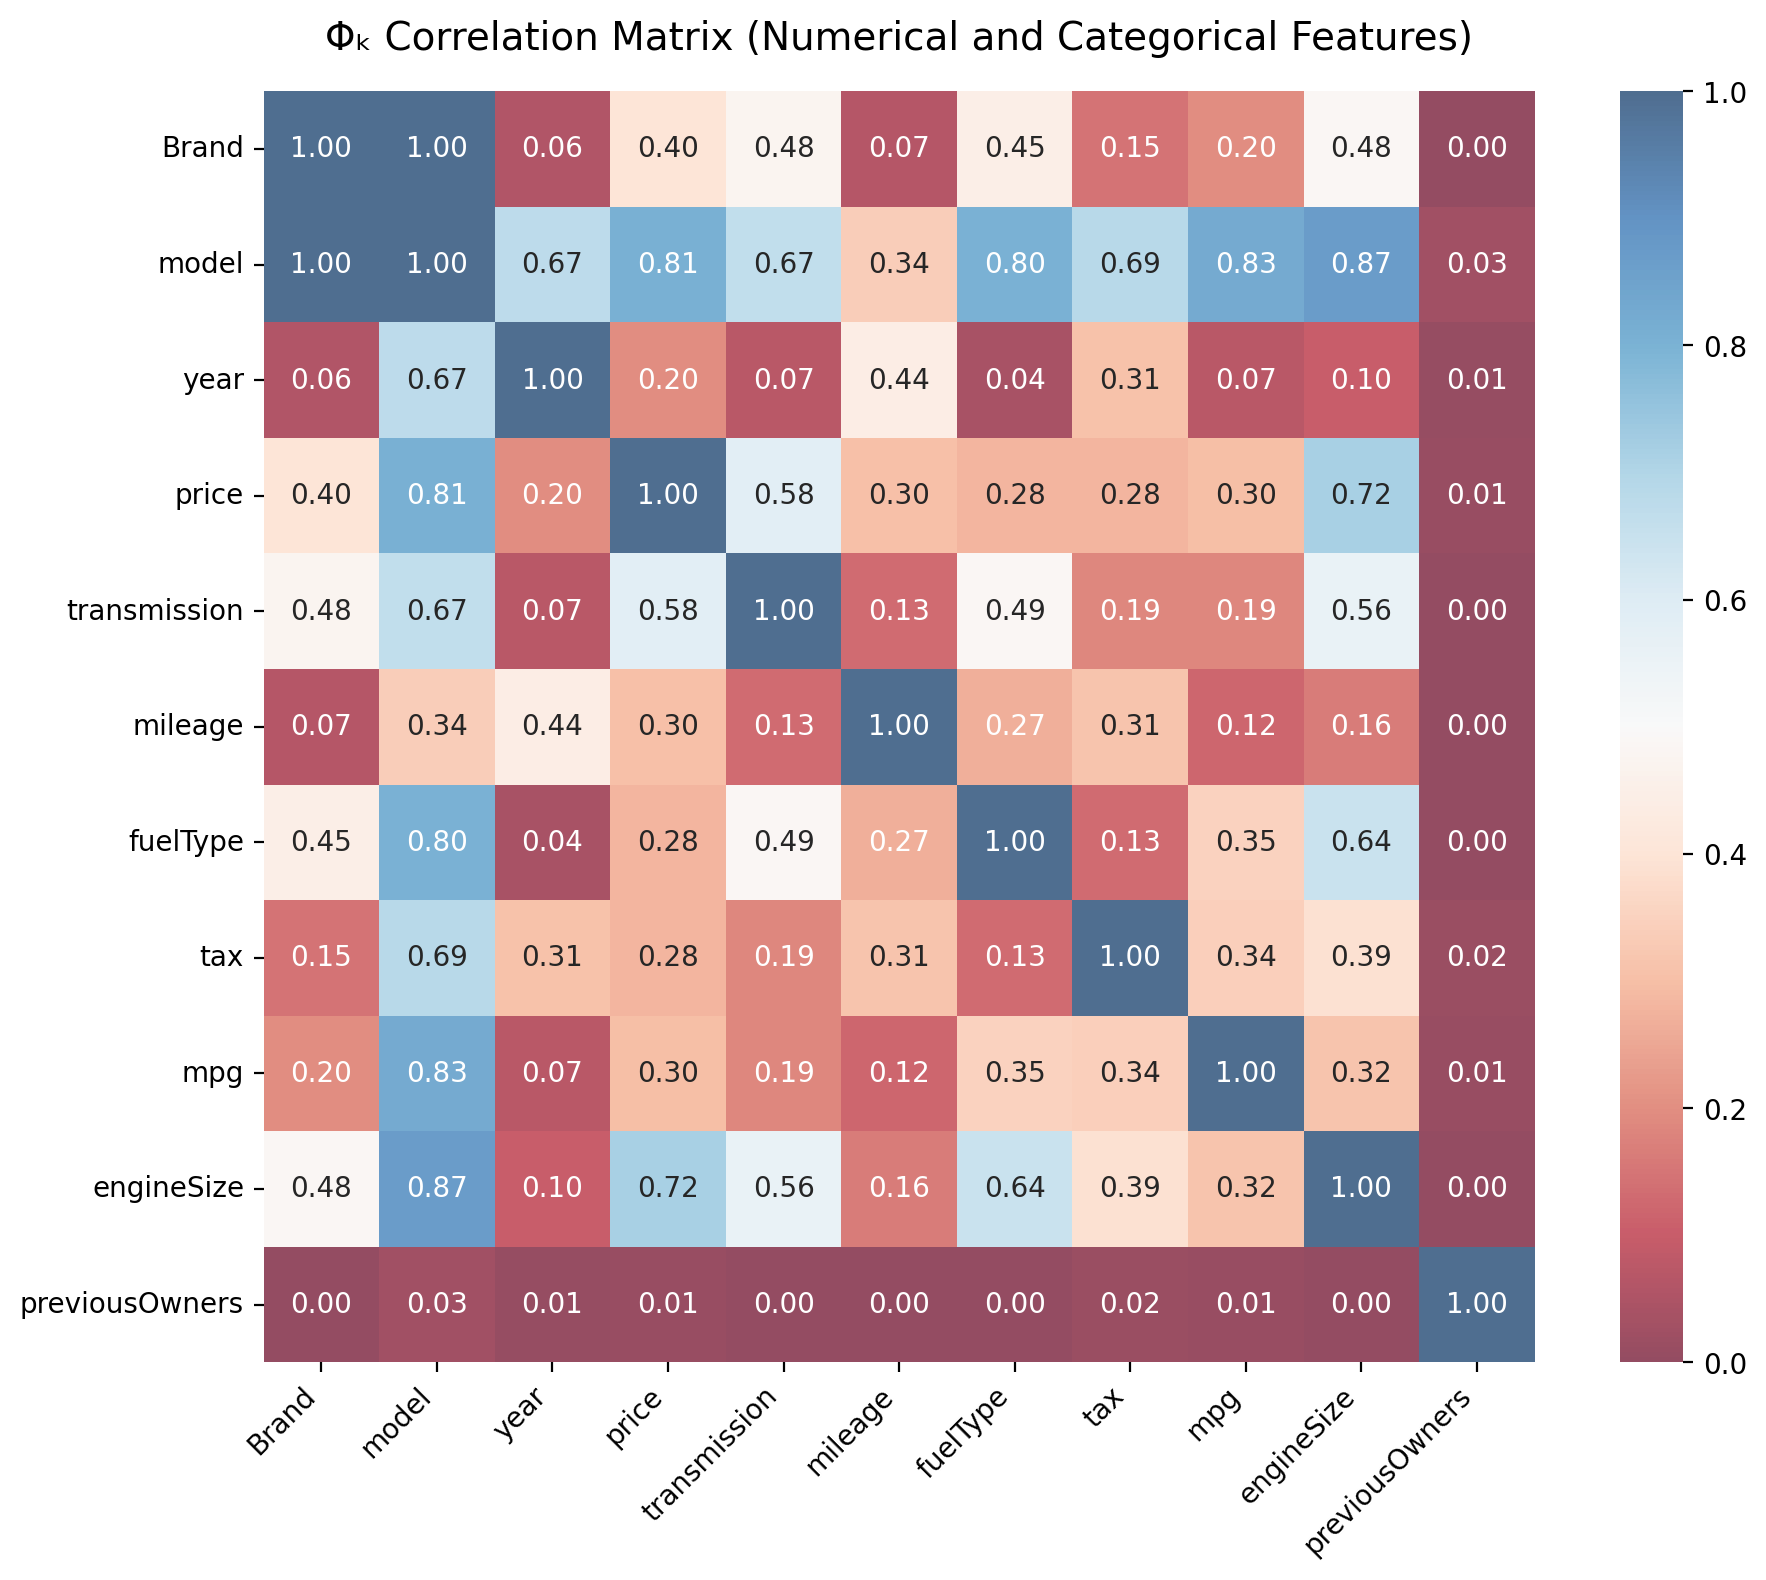

In [145]:
# Φ_k correlation matrix (works with numeric + categorical)
phi_k_corr = df_train.phik_matrix()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    phi_k_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0.5,  # In acordance with the feature scaling
    square=True,
    alpha=0.7,
)

plt.title(
    "Φₖ Correlation Matrix (Numerical and Categorical Features)", fontsize=14, pad=15
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Multivariate analysis was conducted to identify patterns of dependency that may influence model performance. The $\phi_k$ correlation matrix was used to access the interaction between all features both numerical and categorical. $\phi_k$ is a recently proposed association measure that provides a unified framework for quantifying relationships between numerical, ordinal, and categorical variables, while retaining a Pearson-like interpretation for interval-scaled data [3].
The analysis indicates that variables such as model, engine size, fuel type, and transmission exhibit strong associations with vehicle price, suggesting that price formation is driven by a combination of technical specifications and categorical characteristics rather than by any single variable in isolation. At the same time, several predictors show substantial interdependencies, particularly between model and brand, and between engine size, fuel type, and mpg. These relationships highlight the presence of shared information across features, which may lead to redundancy if not properly addressed.

## Assessing Feature Skewness


/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/homebrew/Caskroom/miniconda/base/envs/car_price_env/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis

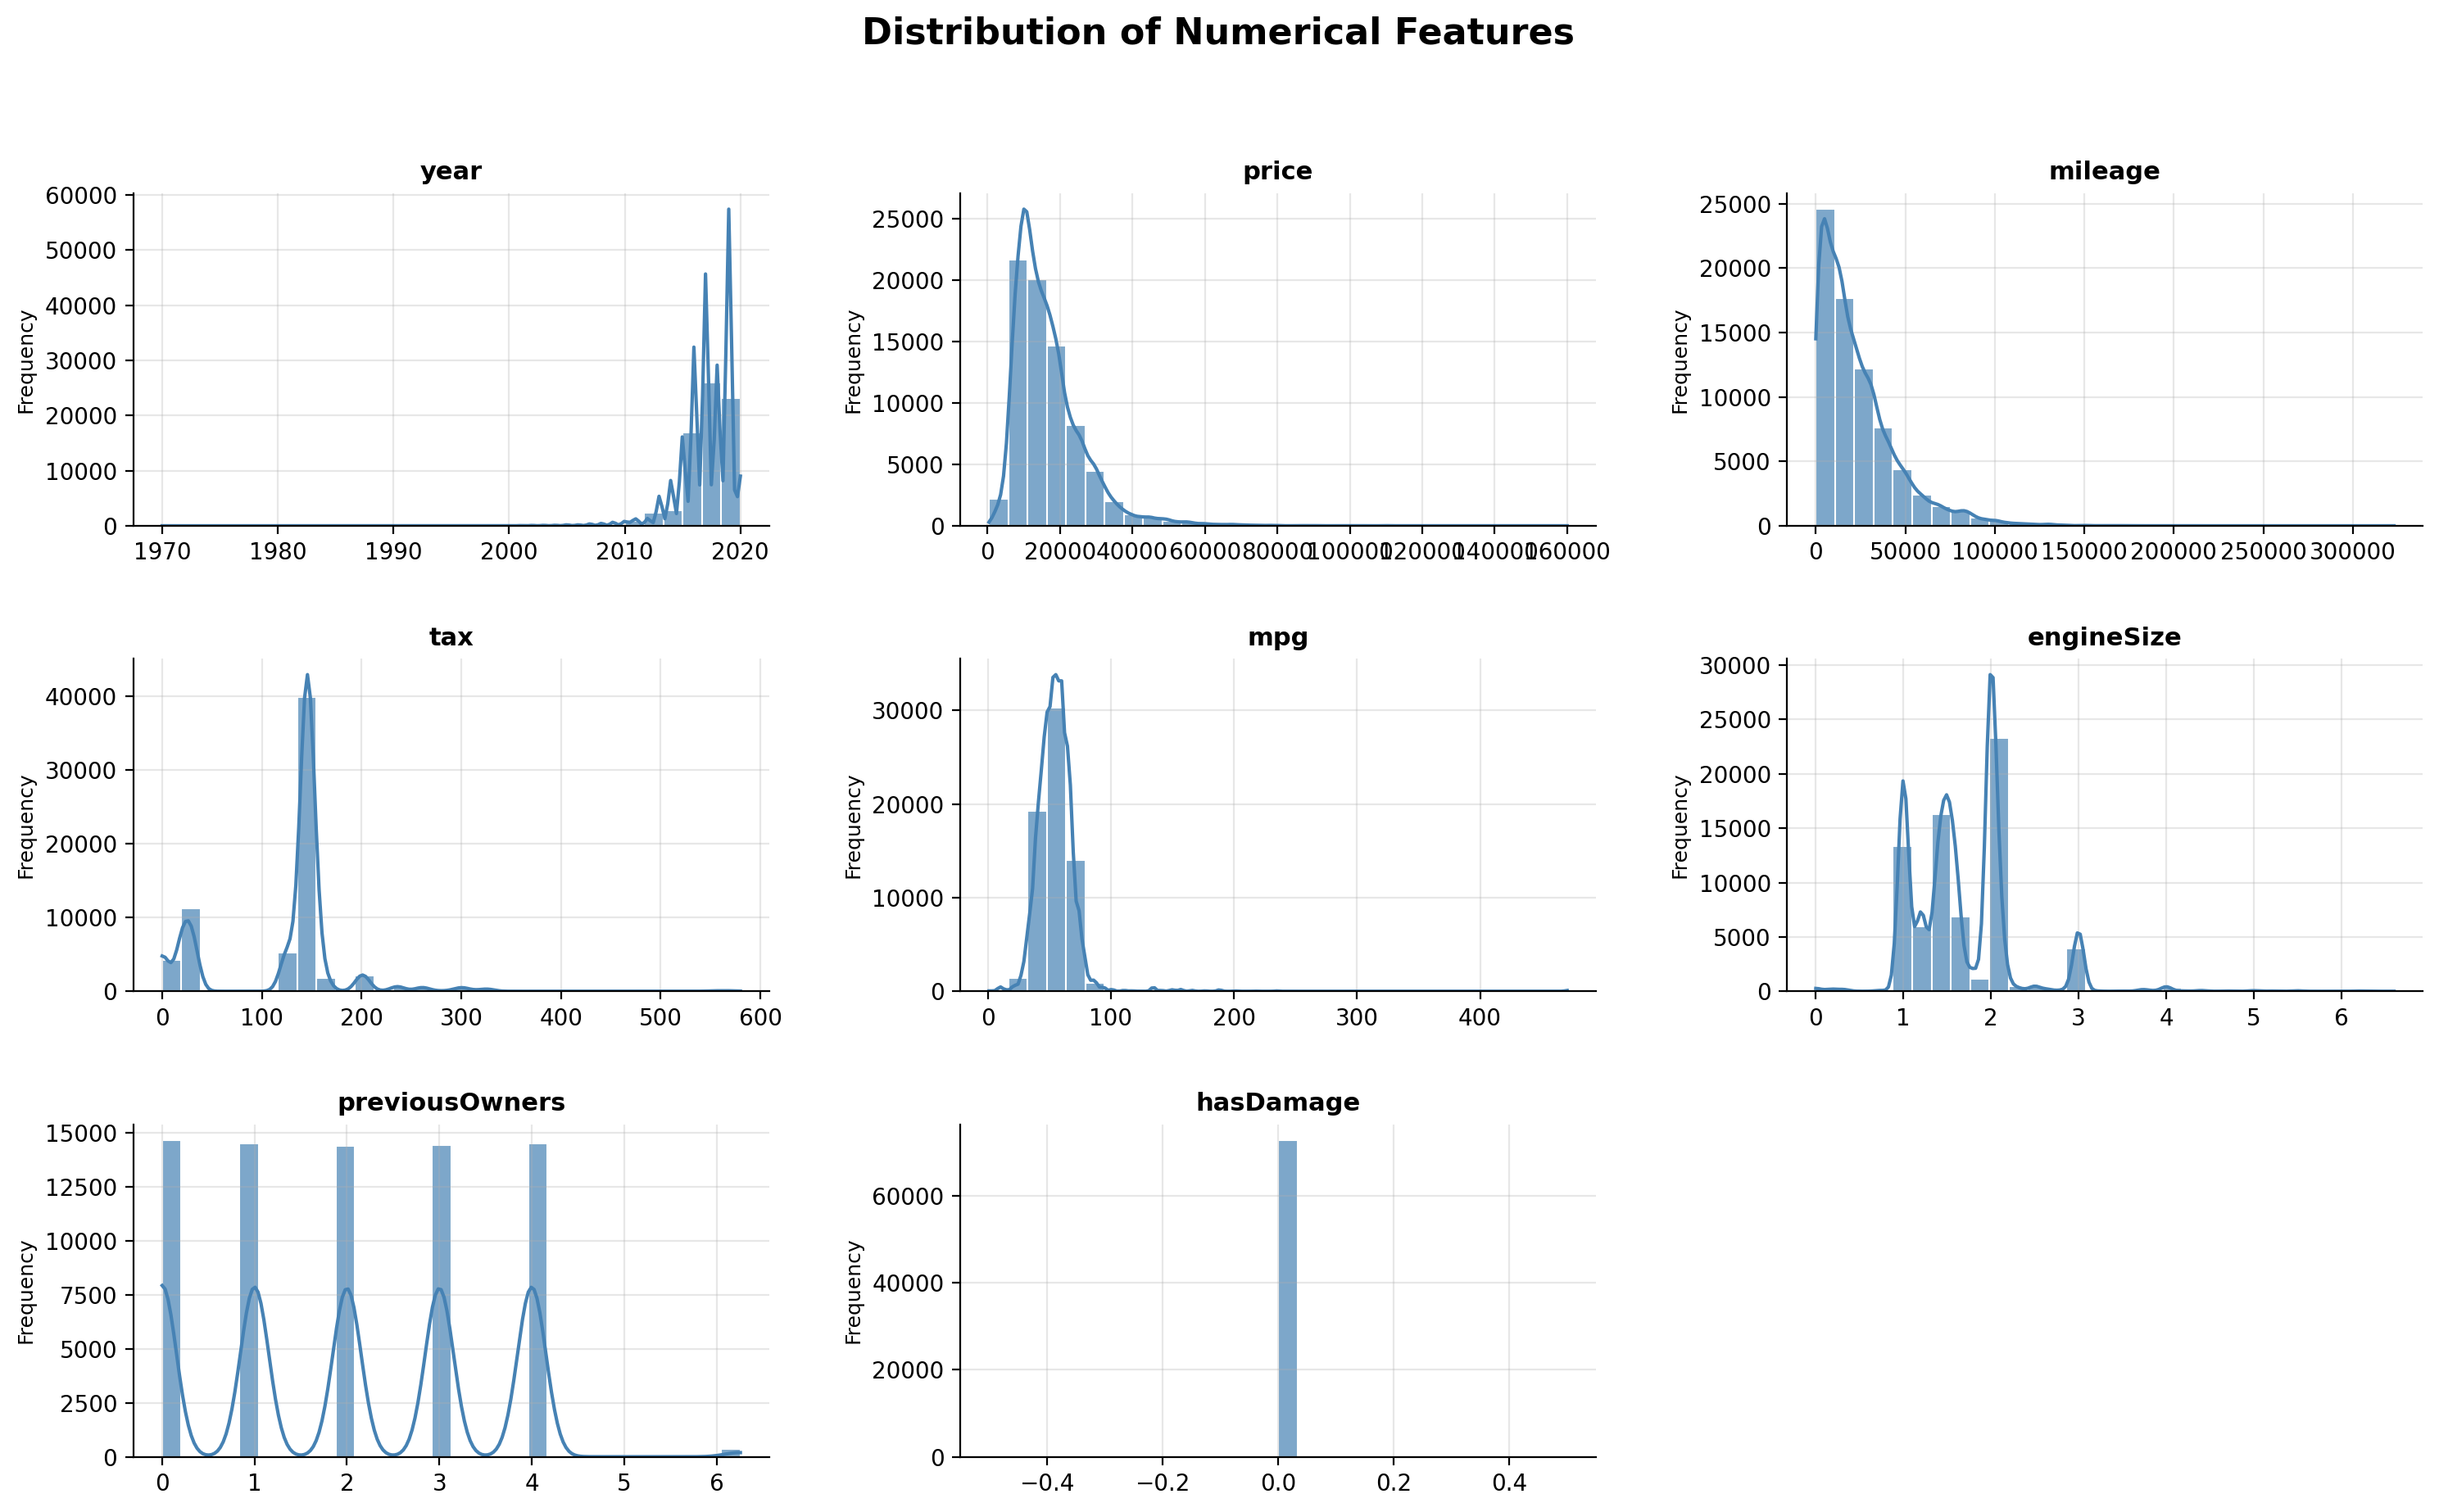

year             -2.050358
price             2.284482
mileage           1.800830
tax               0.114292
mpg               7.541441
engineSize        1.267951
previousOwners    0.086786
hasDamage         0.000000
dtype: float64

In [146]:
# Select numeric columns
numeric_cols = df_train.select_dtypes(exclude="object").columns.tolist()
n_cols = 3  # number of columns in the grid
n_rows = math.ceil(len(numeric_cols) / n_cols)

# Create figure and axes dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(
        data=df_train,
        x=col,
        ax=axes[i],
        bins=30,
        kde=True,
        color="steelblue",
        alpha=0.7,
        edgecolor="white",
    )
    axes[i].set_title(col, fontsize=11, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency", fontsize=9)
    axes[i].grid(alpha=0.3)

# Remove empty subplots (in case total plots < n_rows * n_cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title and layout tweaks
fig.suptitle(
    "Distribution of Numerical Features", fontsize=16, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
sns.despine()
plt.show()

df_train.select_dtypes(exclude="object").skew()


By examining both the distribution plots and the skewness measurements, it can be observed that a substantial proportion of the features in the dataset exhibit skewed distributions. Such skewness may adversely affect model performance and is therefore addressed in the feature engineering stage.

## Feature Engineering

Feature engineering involves creating new variables from existing features in order to enhance model performance. The engineered features introduced in this study are intended to capture underlying relationships and structural patterns that may not be directly observable in the raw data:
1. Logarithmic transformations: Applied to highly skewed continuous variables to mitigate the influence of extreme values and to produce distributions that are closer to normality, which is particularly beneficial for linear and regularised models.

2. Brand–model combination: A composite categorical feature created by concatenating the brand and model attributes, designed to capture brand–model-specific pricing effects that are not fully represented when these variables are considered independently.

In [147]:
log_features = [
    "mileage",
    "mpg",
]
log_skewness = {}
# Log transformations for skewed features and dropping original columns
for feature in log_features:
    df_train[f"log_{feature}"] = np.log1p(df_train[feature])
    df_train.drop(columns=feature, inplace=True)
    log_skewness[f"log_{feature}"] = round(df_train[f"log_{feature}"].skew(), 3)
log_skewness

{'log_mileage': np.float64(-2.247), 'log_mpg': np.float64(-0.712)}

In [148]:
# Create a brand_model feature and drop original columns
df_train["brand_model"] = (
    df_train["Brand"].astype(str) + "_" + df_train["model"].astype(str)
)
df_train.drop(columns=["Brand", "model"], inplace=True)

In [149]:
# Convert 'year' to age
current_year = 2020
df_train["age"] = current_year - df_train["year"]
df_train.drop("year", inplace=True, axis=1)

A substantial reduction in skewness was observed after applying the logarithmic transformation. Consequently, the log-transformed features were retained in the dataset, while the original (non-transformed) variables were removed.

In [150]:
# --- Feature engineer of categorical features --- #
# Create fuelType_model - captures model variants
df_train["fuelType_model"] = df_train["fuelType"] + "_" + df_train["brand_model"]

# Bin engineSize and combine with fuelType
df_train["engineSize_binned"] = pd.cut(
    df_train["engineSize"],
    bins=[0, 1.0, 1.5, 2.0, 2.5, 5.0],
    labels=["tiny", "small", "medium", "large", "huge"],
)

# Engineering 'fuelType' per 'engineSize' feature
df_train["fuelType_engineSize"] = (
    df_train["fuelType"] + "_" + df_train["engineSize_binned"].astype(str)
)
df_train.drop("engineSize", inplace=True, axis=1)

Fuel type exhibited a strong association with the vehicle model. Consequently, these features were combined to capture model-specific fuel configuration patterns. In addition, the engine size variable was discretised into categorical bins to enable its meaningful combination with fuel type, given the observed correlation between these variables. 

### Applying engineered features to the test set

In [151]:
df_test = cleaning_utils.engineer_features(df_test)

In [152]:
df_train.to_csv(os.path.join(CLEANED_DATA_DIR, "cleaned_train_data.csv"))
df_test.to_csv(os.path.join(CLEANED_DATA_DIR, "cleaned_test_data.csv"))